In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import math

def entropy( x, b ):
    s = 0
    for p in x:
        if p > 0:
            s += -p*math.log(p,b)
        # end
    # end
    return s
# end

def visualize_regions(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    prob_2D = model.predict_proba(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end

def visualize_regions_keras(model, MAX, nGrid):
    a1 = np.linspace(-MAX, MAX, nGrid)
    a2 = np.linspace(-MAX, MAX, nGrid)

    A1, A2 = np.meshgrid(a1, a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1, A2)).T

    # Predict B
    B = model.predict(A).argmax(axis=1)
    B = B.reshape(nGrid, nGrid)
    B = np.flipud(B)

    # Compute entropy for S
    #prob_2D = model.predict_proba(A)
    prob_2D = model.predict(A)
    S = np.array([entropy(p, 2) for p in prob_2D])
    S = S.reshape(nGrid, nGrid)
    S = np.flipud(S)

    return B, S
# end

## Create data

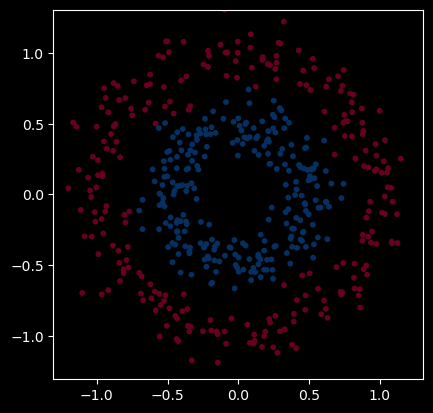

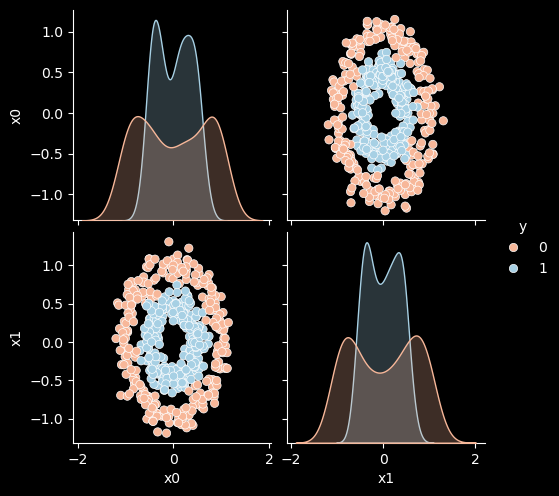

In [3]:
from sklearn.datasets import make_classification, make_blobs, make_moons, make_circles

n_samples = 500

choice = 3

if   choice == 0:
    X, y = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=2,
        cluster_std=4,
        random_state=10
    )
elif choice == 1:
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        random_state=41
    )
elif choice == 2:
    X, y = make_moons(
        n_samples=n_samples,
        noise=0.2,
        random_state=42
    )
elif choice == 3:
    X, y = make_circles(
        n_samples=n_samples,
        noise=0.1,
        factor=0.5,
        random_state=42
    )
# end

X = X - X.mean(axis=0)

MAX = np.max(np.abs(X))

plt.style.use('dark_background')

plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="RdBu");
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.gca().set_aspect('equal')
plt.show()

df = pd.DataFrame( {"x0":X[:,0], "x1":X[:,1], "y":y} )
sns.pairplot(df, hue='y', palette='RdBu')
plt.show()

## Modeling

## Train/test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

## Keras

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

dropout_rate = 0.1

n_classes = np.unique(y).shape[0]

# Create model
model = Sequential([
    Input(shape=X.shape[1:]),
    
    Dense(20, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(20, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(20, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,102 (4.30 KB)

 Trainable params: 1,022 (3.99 KB)

 Non-trainable params: 80 (320.00 B)

# Animate

In [8]:
# Prepare a spatial grid

# set the grid size (nGrid) and range (a1, a2)
nGrid = 200 
a1 = np.linspace(-MAX,MAX,nGrid)  
a2 = np.linspace(-MAX,MAX,nGrid) 

# create a meshgrid 
A1, A2 = np.meshgrid(a1,a2)
A1 = A1.flatten()    # transform 2D matrix of grid points back into a list format
A2 = A2.flatten()
A = np.vstack((A1,A2)).T   # vertical stack and transpose, so that each row of A represents the (x,y) coords of a point 

# setting plot extent 
extent = [-MAX,MAX,-MAX,MAX] 

100%|███████████| 100/100 [01:51<00:00,  1.12s/it]


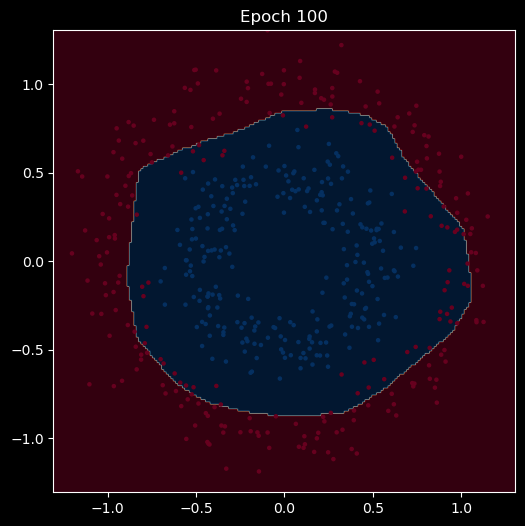

done


In [9]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

def animate(model, epochs, X_train, y_train, X_test, y_test, A, nGrid, filename="classification_training.gif"):
    cmap = 'RdBu'
    fig, ax = plt.subplots(figsize=(7, 6))

    predicted_frames = []  
    for i in tqdm(range(epochs), ncols=50):
        model.fit(X_train, y_train, epochs=1, batch_size=128, validation_data=(X_test, y_test), verbose=0)
        B = model.predict(A, verbose=0).argmax(axis=1).reshape(nGrid, nGrid)
        B = np.flipud(B)
        predicted_frames.append(B)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap=cmap)
    plot = ax.imshow(predicted_frames[0], animated=True, cmap=cmap, alpha=0.5, extent=extent)

    def update(frame):
        plot.set_data(predicted_frames[frame])  
        ax.set_title(f"Epoch {(frame+1)}")  
        return plot,  

    ani = animation.FuncAnimation(fig, update, frames=len(predicted_frames), interval=200, blit=False)

    ani.save(filename, writer='pillow', fps=5)
    plt.show()
    return ani
# end

epochs = 100

animate(model, epochs, X_train, y_train, X_test, y_test, A, nGrid, filename="classification_training.gif")

print("done")